![Closeup photo of dices (Riho Kroll)](./riho-kroll-m4sGYaHYN5o-unsplash.jpg)

Recently I haven taken some interest in network science. There are many things to discuss. For this blog post I would like to share my fascination that $randomization \neq randomization$. In network science, node degree and strength [@2016115] are important properties. 

## Node degree 

In an undirected network the node degree refers to how many edges any given node has. As a linguist, if I wanted to model word relationships using graphs, I need to be aware that word frequency follows a Zipfian distribution. Therefore, the number of connected nodes should follow a similar distribution (if I want to model the same phenomena). Now, provided I wanted to randomise my graph to test wether a specific effect holds, I also need to take care this distribution stays intact.
This is why there are two ways to randomize a network:

### Degree-preserving randomisation

Taking two links and randomly swapping them (possibly with the condition of not generating multi-links)

### Full randomisation

Taking a link, select randomly the source (one of the end), select another random
node that is not connected to the source and rewire.

## Let's shuffle some graphs

In order to showcase the effects of different randomization strategies, we first need a function to randomize our graph:

In [1]:
import networkx as nx
import random

def randomize_graph(graph: nx.Graph, preserve_degree=True) -> nx.Graph:
    """
    Perform (degree-preserving) randomization on a graph.

    :param graph: The input graph to be randomized.
    :param preserve_degree: Wether or not to preserve degree.
    :return networkx.Graph: The randomized graph.
    """
    
    randomized_graph = graph.copy()
    edges = list(randomized_graph.edges)

    if preserve_degree:
        edge1, edge2 = random.sample(edges, 2)
        
        # Check if they are not connected
        if not randomized_graph.has_edge(edge1[0], edge2[1]) and not randomized_graph.has_edge(edge2[0], edge1[1]):
            randomized_graph.remove_edge(*edge1)
            randomized_graph.remove_edge(*edge2)
            randomized_graph.add_edge(edge1[0], edge2[1])
            randomized_graph.add_edge(edge2[0], edge1[1])
    else:
        edge = random.choice(edges)
        source = random.choice(edge)
        allowed_targets = [n for n in randomized_graph.nodes() if n not in randomized_graph.neighbors(source)] + [source]
        if len(allowed_targets):
            target = random.choice(allowed_targets)
            randomized_graph.remove_edge(*edge)
            randomized_graph.add_edge(source, target)

    return randomized_graph


Next we should choose a graph that is particularly sensitive to changes in degree. If we generate a random network with a given degree distribution, such as [gnm_random_graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.gnm_random_graph.html), one would expect suffling of links to have immediate effects on the degree distributions. We can shuffle this graph successivly. You can try this in below's animation:

In [2]:
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100
plt.ioff()

def animate(frame: int, graph: nx.Graph, preserve_degree=True):
    ax.clear()
    graph = randomize_graph(graph, preserve_degree)
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos=pos, ax=ax)

fig, ax = plt.subplots()

n = 200  # 200 nodes
m = 400  # 400 edges
seed = 20160  # seed random number generators for reproducibility

# Use seed for reproducibility
G = nx.gnm_random_graph(n, m, seed=seed)

ani = FuncAnimation(fig, partial(animate, graph=G), frames=20, interval=300)
plt.close()
HTML(ani.to_jshtml())

And of course we need a counter-example where we apply full randomization:

In [3]:
fig, ax = plt.subplots()

G2 = nx.gnm_random_graph(n, m, seed=seed)

ani = FuncAnimation(fig, partial(animate, graph=G2, preserve_degree=False), frames=20, interval=300)
plt.close()
HTML(ani.to_jshtml())

From visual inspection it is only marginally clear that full randomisation actually distorts our graph over time. We can also try and measure this change quantitatively. To do so, we can compare the degree distribution of both graphs over time steps. They should diverge slowly but steadily. According to [@10.1007/978-3-642-30541-2_12] we can expect them to have fully diverged in the following number of steps:

$\frac{E}{2} * \ln{\frac{1}{\epsilon}}$

Generating two identical example graphs yields:

In [4]:
import math
import sys

G3 = nx.gnm_random_graph(n, m, seed=seed)
G4 = nx.gnm_random_graph(n, m, seed=seed)
num_shuffles = (len(G3.edges) / 2) *  math.log( 1 / sys.float_info.epsilon)
num_shuffles

7208.730677823431

We should expect the distributions to have fully diverged by the 7209th iteration. For the sake of simulation, we will consider _10000_ time steps.

/var/folders/k6/hdzmrkf915d0twbr_qmhy9l00000gn/T/ipykernel_8479/1781989036.py:19: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  results.append((step, stats.ks_2samp(degrees, degrees_g4).pvalue, "full"))
/var/folders/k6/hdzmrkf915d0twbr_qmhy9l00000gn/T/ipykernel_8479/1781989036.py:25: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(df, x="step", y="pvalue", hue="method", ax=ax, palette=palette)
/var/folders/k6/hdzmrkf915d0twbr_qmhy9l00000gn/T/ipykernel_8479/1781989036.py:25: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df, x="step", y="pvalue", hue="method", ax=ax, palette=palette)


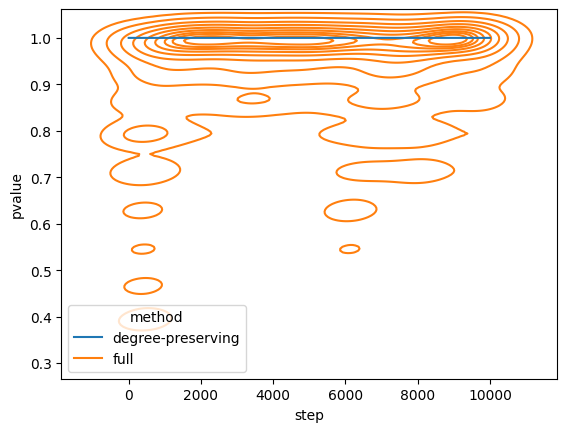

In [5]:
#| label: fig-pvalue-over-time
#| fig-cap: "A density plot of the ks_2samp pvalue over time"

from scipy import stats
import seaborn as sns
import pandas as pd

results = []
steps = list(range(10000))

degrees = [d for n, d in G3.degree()]

for step in steps:
    G3 = randomize_graph(G3)
    G4 = randomize_graph(G4, False)
    degrees_g3 = [d for n, d in G3.degree()]
    degrees_g4 = [d for n, d in G4.degree()]
    results.append((step, stats.ks_2samp(degrees, degrees_g3).pvalue, "degree-preserving"))
    results.append((step, stats.ks_2samp(degrees, degrees_g4).pvalue, "full"))

df = pd.DataFrame(results, columns=["step", "pvalue", "method"])

fig, ax = plt.subplots()
palette = sns.color_palette()
sns.kdeplot(df, x="step", y="pvalue", hue="method", ax=ax, palette=palette)
ax.plot(steps, [1.0] * len(steps), color=palette[0])
plt.show()

In this experiment we can observe two outcomes:

- degree-preserving randomization does not alter the degree of the network (which is why it is at constant _1.0_)
- for full randomization the $p$ clearly drops at _~500_ and _~7000_ steps (as predicted)

However, we would only reject the hyphothesis that the degree distribution of _G4_  and the original graph are independant, if $p \leq 0.05$. Therefore, we can say that the distribution of degrees is still very similar. This seems to contradict [@@10.1007/978-3-642-30541-2_12].